<a href="https://colab.research.google.com/github/GabDada/Healthcare-Analytics/blob/main/DiabetesProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0 - Getting Started

**Introduction**:

In today's growing diabetes population, continuous glucose monitoring offers the potential to change lives and bring fresh insight into how patients manage their conditions. However a number challenges including affordability, awareness and copay limitations still plague widespread utlization. The market is highly competitive as such it has become imperative for Manufacturers to continue growing adoption, reduce churn and compete favourably.  


This project explores the application of data science techniques, specifically segmentation and clustering, to achieve meaningful patient segmentation while uncovering the charcteristics of patients who are less likely to be active after 12 months for different reasons.

Applying segmentation and clustering analysis to patient data, we identified 8 distinct patient groups, their peculiarities, possible reasons for churn, and discuss necessary downstream triggers and market access interventions to grow utilization.



**Methodology:**

*1*: Exploratory Data Analysis: For prelimary insights into the AS-IS business situation.

*2*: S-A-UT Segmentation Framework: Design and Implementation of a state-of-the-art framework (Severity-Affordability- Utilization) for patient segmentation based on market access domain knowledge.  

*3*: Hypothesis Testing: ANOVA to further sense-check results from our Framework.    

*4*: K-Means Clustering: Implemented K-Means clustering analysis to further validate patient segments from the SAUT framewrok.

*5*: Results & Discussions: Business questions are addressed and possible interventions discussed.  





In [1]:
#@title Import Libraries

#Built-in Libraries
import random
import math

#Third-party libraries
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objects as go
#import matplotlib.dates as mdates
#from matplotlib.ticker import MultipleLocator
#from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
#from statsmodels.stats.weightstats import ttest_ind
#from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep

from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

#Disable Warnings
from warnings import filterwarnings
filterwarnings ('ignore')

#Set Seed for np random


Mounted at /content/drive/


In [2]:
#@title Load Data

#Set data path and load data

data_path = '/content/drive/MyDrive/Abbot/Data/Abbotdata.xlsx'


# Load the dataset from the Excel file
dataset = pd.read_excel(data_path, header=0)
print('Data Imported')

Data Imported


In [3]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52818 entries, 0 to 52817
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Patient_ID           52818 non-null  int64 
 1   Diabetes_Type        52818 non-null  object
 2   Patient_Segment      52818 non-null  object
 3   Payer_Group          52818 non-null  object
 4   ADC_Payer_Name       52818 non-null  object
 5   1M_OOP_Bucket        52818 non-null  object
 6   HCP_Specialty_Group  52818 non-null  object
 7   HCP_State            52818 non-null  object
 8   NBRx_Product         52818 non-null  object
 9   Active_Flag          52818 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 4.0+ MB
None


# Step 1- Exploratory Data Analysis

First, lets carry out exploratory data analysis for preliminary diagnostics to glean AS-IS business insights. To do this, we'll observe the summary statistics, and carry out basic univariate and bivariate analysis using business questions.


In [4]:
#@title Table Summary

# Display the first five rows of the present table
columns_to_keep = ['Patient_ID', 'Diabetes_Type','Patient_Segment', 'Payer_Group', 'ADC_Payer_Name', '1M_OOP_Bucket', 'HCP_Specialty_Group', 'HCP_State', 'NBRx_Product', 'Active_Flag' ]
dataset = dataset[columns_to_keep]
dataset.head(5)

,Patient_ID,Diabetes_Type,Patient_Segment,Payer_Group,ADC_Payer_Name,1M_OOP_Bucket,HCP_Specialty_Group,HCP_State,NBRx_Product,Active_Flag
0,85549654,T2,MDI/PP,Medicaid,COOK CNTY HLTH AND HOSP SYS(IL),$0,ENDO,IL,FSL2,1
1,85550109,T2,MDI/PP,Medicaid,UNITED HEALTH GROUP,$0,Unknown,WA,FSL2,0
2,85552099,T2,Non-IUP,Commercial,EXPRESS SCRIPTS - (ESI),$0,PCP,NY,FSL2,0
3,85556738,T2,Non-IUP,Medicare,BCBS EMPIRE/WELLCHOICE,$0,PCP,NY,FSL2,0
4,85565307,T2,Non-IUP,Cash,ALL OTHER COUPON PROGRAMS,$20.01 - $40.00,ENDO,FL,FSL2,0


In [5]:
#Summary statistics
#A. How many rows are there in the table?
#B. How many columns are there in the table?
#C. Show descriptives?
#D. Any missing / null fields?

print ('Number of Rows:', dataset.shape[0])
print ('Number of Columns:', dataset.shape[1])
#dataset.info()
dataset.describe()
dataset.isnull().mean()

Number of Rows: 52818
Number of Columns: 10


,0
Patient_ID,0.0
Diabetes_Type,0.0
Patient_Segment,0.0
Payer_Group,0.0
ADC_Payer_Name,0.0
1M_OOP_Bucket,0.0
HCP_Specialty_Group,0.0
HCP_State,0.0
NBRx_Product,0.0
Active_Flag,0.0


In [6]:
#@title Understanding the Business

#What is our currrent Patients Retention Outlook?

#A. How many unique patients do we have?
#B. How many were dropped off after one year were there?
#C. What is the dropp off rate?


total_rows = len(dataset)
droppoff_flags = (dataset["Active_Flag"] == 0).sum()
retained_flags = (dataset["Active_Flag"] == 1).sum()
droppoff_rate = (droppoff_flags / total_rows) * 100

print(dataset["Patient_ID"].nunique(), ':Unique Patients')
print((dataset["Active_Flag"] == 0).sum(), ':Churned before one year')
print((dataset["Active_Flag"] == 1).sum(), ':were Retained')
print((droppoff_flags / total_rows) * 100, ': of patients fell off product before one year')

52818 :Unique Patients
33135 :Churned before one year
19683 :were Retained
62.734295126661365 : of patients fell off product before one year


In [7]:
#Estimate the contribution of key independent business attributes to traction.

#A. What is the size of our largest Patient Segment by Treatment Regimen?
#B. What is the breakdown of disease severity by type? Can we juxtapose this the general population (market)?
#C. What Payer Category Drives the most reimbursement in terms of volume?
#D. What are the most prescribed Abbot products?
#E. Which HCP Specialty group are driving the most volume
#F: Are there any dfinitions that need to be clarified? E.g 'Unkmown'

# To do this lets do some univaruate analysis to inspect patient counts for some attributes.

import plotly.subplots as sp
import plotly.graph_objects as go

# Columns to plot and Inspect
categorical_columns = ['Diabetes_Type', 'Patient_Segment', 'Payer_Group', '1M_OOP_Bucket', 'NBRx_Product', 'HCP_Specialty_Group']
fig = sp.make_subplots(rows=1, cols=len(categorical_columns), subplot_titles=categorical_columns)

# Iterate through each categorical column to create individual bar plots
for i, column in enumerate(categorical_columns):
    # Get value counts for the column
    value_counts = dataset[column].value_counts()

    # Add a bar plot for the column
    fig.add_trace(
        go.Bar(x=value_counts.index, y=value_counts.values, name=column, text=value_counts.values, textposition='auto'),
        row=1, col=i+1
    )

# Update layout for better visualization
fig.update_layout(
    title_text='Univariate Distributions of Categorical Columns',
    showlegend=False,
    height=600, width=1500
)

# Show plot
fig.show()

In [8]:
#What is the the churn situation like?  We can inspect this across our attributes of interest.

#A. What Abbot product categories had the highest churn rate?
#B. What Diabetes categories had the highest churn rate?
#C. What Payer Category contributed to the most churn?
#D. Which HCP Specialty contributed to the most churn?

# We can do some bivariate analysis with Group By

# Lets add a 'Churn' column based on the 'Active_Flag' column
dataset['Churn'] = dataset['Active_Flag'].apply(lambda x: 'Churn' if x == 0 else 'Active')

# Columns to evaluate against churn
categorical_columns = ['Diabetes_Type', 'Patient_Segment', 'Payer_Group', '1M_OOP_Bucket', 'NBRx_Product', 'HCP_Specialty_Group']

# Subplot with one row and multiple columns
fig = sp.make_subplots(rows=1, cols=len(categorical_columns), subplot_titles=categorical_columns)

# Iteration through each categorical column to create individual bar plots
for i, column in enumerate(categorical_columns):
    # Get the count of each category grouped by churn status
    churn_counts = dataset.groupby([column, 'Churn']).size().reset_index(name='Count')

    # Add a bar plot for each churn status
    for churn_status in churn_counts['Churn'].unique():
        # Filter the churn status data
        churn_data = churn_counts[churn_counts['Churn'] == churn_status]

        fig.add_trace(
            go.Bar(x=churn_data[column], y=churn_data['Count'], name=f"{column} - {churn_status}", text=churn_data['Count'], textposition='auto'),
            row=1, col=i+1
        )

# Update layout for better visualization
fig.update_layout(
    title_text='Distribution of Categorical Columns Against Churn',
    showlegend=True,barmode='group',  # Group bars for better comparison
    height=600, width=1600
)

# Show plot
fig.show()


In [9]:
#Let's focus on churn count and evaluate against some column pairs.


# Create a 'Churn' column based on the 'Active_Flag' column
dataset['Churn'] = dataset['Active_Flag'].apply(lambda x: 'Churn' if x == 0 else 'Active')

# Filter the data to only include churned records
churn_df = dataset[dataset['Churn'] == 'Churn']

# Define the pairs of columns to plot heatmaps
heatmap_pairs = [
    ('Diabetes_Type', 'Patient_Segment'),
    ('Payer_Group', '1M_OOP_Bucket'),
    ('HCP_Specialty_Group', 'NBRx_Product')
]

# Create a subplot with one row and multiple columns
fig = sp.make_subplots(rows=1, cols=len(heatmap_pairs), subplot_titles=[f"{x} vs {y}" for x, y in heatmap_pairs])

# Iterate through each pair to create individual heatmaps
for i, (x_col, y_col) in enumerate(heatmap_pairs):
    # Get the count of churned records for each pair combination
    heatmap_data = churn_df.groupby([x_col, y_col]).size().reset_index(name='Churn Count')

    # Create a pivot table to use for the heatmap
    heatmap_pivot = heatmap_data.pivot(index=y_col, columns=x_col, values='Churn Count').fillna(0)

    # Add a heatmap for the pair
    fig.add_trace(
        go.Heatmap(
            z=heatmap_pivot.values,
            x=heatmap_pivot.columns,
            y=heatmap_pivot.index,
            colorscale='Blues',
            colorbar=dict(title="Churn Count"),
            hoverongaps=False
        ),
        row=1, col=i+1
    )

# Update layout for better visualization
fig.update_layout(
    title_text='Bivariate Analysis for Churn Count',
    height=600, width=1800
)

# Show plot
fig.show()

In summary preliminary analysis of our market situation show that:

* About 63% of all patients who were once active fall out/churn within a year.  

* Patients with 'Unknown' diabetes type on Oral   Non-IUP treatment regimen accounted for the largest churn at 10k, followed closely by Type 2 diabetes patients on around 9k.  

* Similarly, Patients on commercial insurance with '1M OOP'cost between $60-$75 accounted for the most churn at 10k followed by Cash category with $>75 '1M OOP' cost.

* 'FSL2' product prescribed by 'PCP' accounted for the most churn at 14K, followed by FSL 2 by Endocrinologists at 7k, and FSL 14D by PCP respectively.



# Step 2- Implementing the S-A-UT Framework

In [10]:
#@title Introduction




The framework uses attributes such as Diabetes_Type, Patient_Segment, Payer_Group,  and 1M OOP to compute Severity, Affordability and Utilization for each patient profile.

A number of factors influence consumer healthcare spending including physicians' practice speciality & attributes, marketing & promotion, brand equity, restrictions & prior authorization, etc. However Critical drivers for patients include:  

* Efficacy: Is the medication clinically efficient enough to treat my condition?
* Cost Effectivenss: How affordable is it? What are my copay options and Are there alternatives?

[Source: National Library of Medicine. Ethiop J Health Sci. 2018 Nov; 28(6): 795–804.
doi: 10.4314/ejhs.v28i6.15 *italicized text*]











In [ ]:
#@title Design the Scoring Framework

Attributes are combined as follow:

* Severity of the Disease - Patient Segment + Diabetes Type
* Affordability of the interventions - Payer Group + 1M OOP + HDI_Rank (Feature Engineered)
* Utilization of the interventions -  NBRx Product + HCP Category Group



In [11]:
#  Create a dataframe that includes the specified columns Diabetes_Type, Patient_Segment, Payer_Group, 1M OOP

# Select the specified columns for the new dataframe
columns_to_keep = ['Patient_ID', 'Diabetes_Type','Patient_Segment', 'NBRx_Product', 'HCP_Specialty_Group', 'HCP_State', 'Payer_Group', '1M_OOP_Bucket', 'Active_Flag' ]
segment_attributes = dataset[columns_to_keep]


ANOVA check if attributes explains the variance in the target variable (i.e Active Flag vs Inactive Flag)

In [12]:
#  Check the Analysis of Variance between each columns on active_flag and exclude some columns

def check_aov(df, target_col, exclude_cols):
  """
  Performs ANOVA test for each column in the DataFrame against the target column,
  excluding specified columns.

  Args:
    df: The pandas DataFrame.
    target_col: The name of the target column.
    exclude_cols: A list of column names to exclude from the analysis.

  Returns:
    None. Prints the results of the ANOVA tests.
  """
  for column in df.columns:
    if column != target_col and column not in exclude_cols:
      groups = df[column].unique()
      group_data = [df[df[column] == group][target_col] for group in groups]
      fvalue, pvalue = stats.f_oneway(*group_data)
      print(f"ANOVA for {column} vs {target_col}: F-value = {fvalue:.2f}, p-value = {pvalue:.3f}")

# Call the function
exclude_columns = ['Patient_ID']
check_aov(segment_attributes, 'Active_Flag', exclude_columns)


ANOVA for Diabetes_Type vs Active_Flag: F-value = 445.15, p-value = 0.000
ANOVA for Patient_Segment vs Active_Flag: F-value = 466.16, p-value = 0.000
ANOVA for NBRx_Product vs Active_Flag: F-value = 61.99, p-value = 0.000
ANOVA for HCP_Specialty_Group vs Active_Flag: F-value = 187.63, p-value = 0.000
ANOVA for HCP_State vs Active_Flag: F-value = 8.12, p-value = 0.000
ANOVA for Payer_Group vs Active_Flag: F-value = 249.36, p-value = 0.000
ANOVA for 1M_OOP_Bucket vs Active_Flag: F-value = 189.11, p-value = 0.000


P-value < 0.05 hence we reject the null hypothesis as the we are 95% confident that vraiance in the active flag can be explained by each of our contributor variable.

In [13]:
#Feature Engineering: Creation of HDI Rank for US States 2022 - Source UNDP Data 2022
#HDI provides indications for standard of living, how educated and knowledgeable a population is.
USState = dataset['HCP_State'].unique()
print(USState)

#Create the DataFrame using data from UNDP website
#for Armed Forces Pacific AP, Armed Forces Europe use average HDI in the region
#for Unkown use Average HDI for the known states
data = {
    'State': ['IL', 'WA', 'NY', 'FL', 'TX', 'PA', 'KS', 'AL', 'VA', 'CA', 'CO', 'NV', 'AZ', 'OH',
              'TN', 'NJ', 'IN', 'MI', 'WV', 'LA', 'ND', 'MD', 'ID', 'ME', 'OR', 'MA', 'NC', 'GA',
              'AR', 'KY', 'UT', 'SC', 'MO', 'MS', 'WI', 'SD', 'Unknown', 'RI', 'NE', 'PR', 'DE',
              'IA', 'MN', 'WY', 'OK', 'NH', 'HI', 'AK', 'CT', 'VT', 'NM', 'MT', 'DC', 'VI', 'AP',
              'Wa', 'GU', 'AE'],
    'HDI': [0.935, 0.936, 0.946, 0.917, 0.913, 0.929, 0.928, 0.886, 0.913, 0.937, 0.948, 0.909, 0.914, 0.920,
            0.890, 0.949, 0.913, 0.919, 0.872, 0.894, 0.948, 0.942, 0.912, 0.923, 0.936, 0.957, 0.913, 0.910,
            0.886, 0.890, 0.921, 0.899, 0.913, 0.872, 0.936, 0.933, 0, 0.931, 0.939, 0.872, 0.937,
            0.936, 0.953, 0.921, 0.901, 0.949, 0.946, 0.938, 0.956, 0.923, 0.907, 0.921, 0.947, 0.894, 0.92,
            0.936, 0.872, 0.90]
}

HDI_df = pd.DataFrame(data)

# Dealing with 'Unknown value' using Mean Insertion
HDI_df.loc[HDI_df['State'] == 'Unknown', 'HDI'] = np.nan #Replace HDI value for 'Unknown' state with NaN
average_hdi = HDI_df['HDI'].mean() # Calculate the average HDI for known states
HDI_df['HDI'] = HDI_df['HDI'].fillna(average_hdi)# Fill 'Unknown' or missing HDI values with the average HDI

#Calculate the quantiles and rank HDI
HDI_df['HDI_Rank'] = pd.qcut(HDI_df['HDI'], 4, labels=[1, 2, 3, 4])

segment_attributes = segment_attributes.merge(HDI_df, left_on='HCP_State', right_on='State', how='left')
#  round HDI column to 3 decimal places
segment_attributes['HDI'] = segment_attributes['HDI'].round(3)
print(segment_attributes.head())


['IL' 'WA' 'NY' 'FL' 'TX' 'PA' 'KS' 'AL' 'VA' 'CA' 'CO' 'NV' 'AZ' 'OH'
 'TN' 'NJ' 'IN' 'MI' 'WV' 'LA' 'ND' 'MD' 'ID' 'ME' 'OR' 'MA' 'NC' 'GA'
 'AR' 'KY' 'UT' 'SC' 'MO' 'MS' 'WI' 'SD' 'Unknown' 'RI' 'NE' 'PR' 'DE'
 'IA' 'MN' 'WY' 'OK' 'NH' 'HI' 'AK' 'CT' 'VT' 'NM' 'MT' 'DC' 'VI' 'AP'
 'Wa' 'GU' 'AE']
   Patient_ID Diabetes_Type Patient_Segment NBRx_Product HCP_Specialty_Group  \
0    85549654            T2          MDI/PP         FSL2                ENDO   
1    85550109            T2          MDI/PP         FSL2             Unknown   
2    85552099            T2         Non-IUP         FSL2                 PCP   
3    85556738            T2         Non-IUP         FSL2                 PCP   
4    85565307            T2         Non-IUP         FSL2                ENDO   

  HCP_State Payer_Group    1M_OOP_Bucket  Active_Flag State    HDI HDI_Rank  
0        IL    Medicaid               $0            1    IL  0.935        3  
1        WA    Medicaid               $0            0    WA  0

In [14]:
# A. Create Attributes for Severity, Affordability and Utilization
segment_attributes['Severity'] = segment_attributes['Patient_Segment'] + ' - ' + segment_attributes['Diabetes_Type']
segment_attributes['Utilization'] = segment_attributes['NBRx_Product'] + ' - ' + segment_attributes['HCP_Specialty_Group']
segment_attributes['Affordability'] = segment_attributes['Payer_Group'] + ' - ' + segment_attributes['1M_OOP_Bucket'] + ' - '+segment_attributes['HDI_Rank'].astype(str)

In [15]:
#B. Assign Scores for Severity, Affordability & Utilization

#For Severity:
# Step 1: Get unique values of Severity combinations
severity = segment_attributes['Severity'].unique()
print("Unique Severity values:", severity)
severity=pd.DataFrame(severity, columns=['Category_s'])

#Lets assign severity scores based on inference from Subject Matter Knowledge: 1 - Most Severe ; 4 - Least Severe
#Type 1 Diabetes: Generally, more severe because the body does not produce insulin, and patients require lifelong insulin therapy.
#Type 2 Diabetes: Severity Can vary, but generally less severe than Type 1 as the body produces/ sometimes oversecrets insulin but unable to function to effectively regulate glucose.
#Type Unknown: Severity is uncertain without clear classification, but it may indicate an undefined or less controlled situation, which can have its own risks.
#Treatment Regimen:
#MDI/PP: Indicates a more intensive insulin therapy typically associated with severe cases. Might include a combination of long-acting insulin (BASAl) & rapid shot (BOLUS) ..adminstered 3+ times daily
#Basal: Indicates a less intensive  insulin therapy with long-acting / background insulin (BASAl) administered to keep glucose level steady.
#Non-IUP: Suggests that the patient is managing their diabetes with non-intensive treatment, potentially indicating a less severe condition with Oral Drugs use.

# Based on the Above: Patients with Diabetes Type 1 on MDI/PP tretament is Most Severe (1)
severity_scores = {
    'MDI/PP - T1': 1,
    'Basal - T1': 1,
    'Non-IUP - T1': 1,
    'MDI/PP - T2': 2,
    'MDI/PP - Unknown': 2,
    'Basal - T2': 3,
    'Basal - Unknown': 3,
    'Non-IUP - T2': 4,
    'Non-IUP - Unknown': 4
}
# Step 2: Map the scores to the DataFrame
severity['Score_s'] = severity['Category_s'].map(severity_scores)
print(severity)

Unique Severity values: ['MDI/PP - T2' 'Non-IUP - T2' 'Non-IUP - Unknown' 'Basal - Unknown'
 'Basal - T2' 'MDI/PP - Unknown' 'Non-IUP - T1' 'MDI/PP - T1' 'Basal - T1']
          Category_s  Score_s
0        MDI/PP - T2        2
1       Non-IUP - T2        4
2  Non-IUP - Unknown        4
3    Basal - Unknown        3
4         Basal - T2        3
5   MDI/PP - Unknown        2
6       Non-IUP - T1        1
7        MDI/PP - T1        1
8         Basal - T1        1


In [16]:
#For Affordability:
affordability = segment_attributes['Affordability'].unique()
print("Unique Affordability values:", affordability)

Unique Affordability values: ['Medicaid - $0 - 3' 'Commercial - $0 - 4' 'Medicare - $0 - 4'
 'Cash - $20.01 - $40.00 - 2' 'Commercial - $20.01 - $40.00 - 2'
 'Commercial - $0 - 3' 'Commercial - $60.01 - $75.00 - 3'
 'Commercial - $60.01 - $75.00 - 1' 'Commercial - $60.01 - $75.00 - 2'
 'Commercial - >$75 - 4' 'Commercial - $60.01 - $75.00 - 4'
 'Cash - $0 - 1' 'Medicaid - $0 - 2' 'Medicare - $0 - 1'
 'Commercial - $0.01 - $20.00 - 2' 'Cash - >$75 - 3'
 'Commercial - $20.01 - $40.00 - 4' 'Medicaid - $0 - 4' 'Cash - $0 - 2'
 'Cash - >$75 - 2' 'Commercial - $20.01 - $40.00 - 1'
 'Commercial - $0 - 2' 'Cash - >$75 - 1'
 'Commercial - $40.01 - $60.00 - 3' 'Commercial - >$75 - 1'
 'Cash - $60.01 - $75.00 - 2' 'Medicare - $20.01 - $40.00 - 3'
 'Medicare - $0 - 2' 'Cash - >$75 - 4' 'Commercial - $0 - 1'
 'Commercial - $20.01 - $40.00 - 3' 'Cash - Unknown - 4'
 'Medicare - $20.01 - $40.00 - 2' 'Cash - $60.01 - $75.00 - 1'
 'Medicare - $0.01 - $20.00 - 3' 'Commercial - >$75 - 2' 'Cash - $0 - 4'


In [22]:
#  print unique affordability from the segment_attributes table with comma and single quote in each

affordability = segment_attributes['Affordability'].unique()
print("Unique Affordability values: ", ", ".join(f"'{item}'" for item in affordability))


Unique Affordability values:  'Medicaid - $0 - 3', 'Commercial - $0 - 4', 'Medicare - $0 - 4', 'Cash - $20.01 - $40.00 - 2', 'Commercial - $20.01 - $40.00 - 2', 'Commercial - $0 - 3', 'Commercial - $60.01 - $75.00 - 3', 'Commercial - $60.01 - $75.00 - 1', 'Commercial - $60.01 - $75.00 - 2', 'Commercial - >$75 - 4', 'Commercial - $60.01 - $75.00 - 4', 'Cash - $0 - 1', 'Medicaid - $0 - 2', 'Medicare - $0 - 1', 'Commercial - $0.01 - $20.00 - 2', 'Cash - >$75 - 3', 'Commercial - $20.01 - $40.00 - 4', 'Medicaid - $0 - 4', 'Cash - $0 - 2', 'Cash - >$75 - 2', 'Commercial - $20.01 - $40.00 - 1', 'Commercial - $0 - 2', 'Cash - >$75 - 1', 'Commercial - $40.01 - $60.00 - 3', 'Commercial - >$75 - 1', 'Cash - $60.01 - $75.00 - 2', 'Medicare - $20.01 - $40.00 - 3', 'Medicare - $0 - 2', 'Cash - >$75 - 4', 'Commercial - $0 - 1', 'Commercial - $20.01 - $40.00 - 3', 'Cash - Unknown - 4', 'Medicare - $20.01 - $40.00 - 2', 'Cash - $60.01 - $75.00 - 1', 'Medicare - $0.01 - $20.00 - 3', 'Commercial - >$75 -

In [23]:
# Unique affordability
data = [
   'Medicaid - $0 - 3', 'Commercial - $0 - 4', 'Medicare - $0 - 4', 'Cash - $20.01 - $40.00 - 2', 'Commercial - $20.01 - $40.00 - 2', 'Commercial - $0 - 3', 'Commercial - $60.01 - $75.00 - 3',
   'Commercial - $60.01 - $75.00 - 1', 'Commercial - $60.01 - $75.00 - 2', 'Commercial - >$75 - 4', 'Commercial - $60.01 - $75.00 - 4', 'Cash - $0 - 1', 'Medicaid - $0 - 2', 'Medicare - $0 - 1',
   'Commercial - $0.01 - $20.00 - 2', 'Cash - >$75 - 3', 'Commercial - $20.01 - $40.00 - 4', 'Medicaid - $0 - 4', 'Cash - $0 - 2', 'Cash - >$75 - 2', 'Commercial - $20.01 - $40.00 - 1',
   'Commercial - $0 - 2', 'Cash - >$75 - 1', 'Commercial - $40.01 - $60.00 - 3', 'Commercial - >$75 - 1', 'Cash - $60.01 - $75.00 - 2', 'Medicare - $20.01 - $40.00 - 3', 'Medicare - $0 - 2',
   'Cash - >$75 - 4', 'Commercial - $0 - 1', 'Commercial - $20.01 - $40.00 - 3', 'Cash - Unknown - 4', 'Medicare - $20.01 - $40.00 - 2', 'Cash - $60.01 - $75.00 - 1', 'Medicare - $0.01 - $20.00 - 3',
   'Commercial - >$75 - 2', 'Cash - $0 - 4', 'Commercial - $0.01 - $20.00 - 4', 'Medicare - $0 - 3', 'Commercial - $40.01 - $60.00 - 1', 'Cash - $20.01 - $40.00 - 1', 'Medicare - $0.01 - $20.00 - 4',
   'Commercial - $0.01 - $20.00 - 1', 'Cash - $40.01 - $60.00 - 2', 'Commercial - >$75 - 3', 'Commercial - $40.01 - $60.00 - 4', 'Cash - $60.01 - $75.00 - 3', 'Commercial - $0.01 - $20.00 - 3',
   'Commercial - Unknown - 1', 'Commercial - Unknown - 2', 'Medicaid - $20.01 - $40.00 - 3', 'Cash - Unknown - 3', 'Cash - $20.01 - $40.00 - 3', 'Medicare - >$75 - 4', 'Medicaid - $0.01 - $20.00 - 1',
   'Cash - Unknown - 2', 'Commercial - Unknown - 4', 'Medicaid - $60.01 - $75.00 - 2', 'Medicaid - $20.01 - $40.00 - 1', 'Commercial - $40.01 - $60.00 - 2', 'Medicare - $60.01 - $75.00 - 4', 'Cash - $0.01 - $20.00 - 1',
   'Medicaid - $0 - 1', 'Cash - $60.01 - $75.00 - 4', 'Medicaid - $20.01 - $40.00 - 4', 'Medicare - $20.01 - $40.00 - 1', 'Medicaid - $20.01 - $40.00 - 2', 'Medicare - >$75 - 2', 'Cash - $0 - 3', 'Medicare - $60.01 - $75.00 - 3',
   'Cash - $0.01 - $20.00 - 2', 'Medicaid - >$75 - 4', 'Medicaid - $0.01 - $20.00 - 4', 'Cash - $20.01 - $40.00 - 4', 'Cash - $0.01 - $20.00 - 4', 'Medicare - Unknown - 4', 'Medicare - $0.01 - $20.00 - 2', 'Medicare - >$75 - 3',
   'Medicare - >$75 - 1', 'Cash - $0.01 - $20.00 - 3', 'Cash - Unknown - 1', 'Government - $20.01 - $40.00 - 2', 'Medicare - $40.01 - $60.00 - 1', 'Medicare - $0.01 - $20.00 - 1', 'Medicare - $20.01 - $40.00 - 4',
   'Medicaid - $0.01 - $20.00 - 2', 'Commercial - Unknown - 3', 'Medicare - $60.01 - $75.00 - 2', 'Medicaid - $60.01 - $75.00 - 4', 'Government - $0 - 2', 'Government - >$75 - 2', 'Medicaid - >$75 - 2', 'Medicare - $40.01 - $60.00 - 3',
   'Medicare - Unknown - 3', 'Government - $0.01 - $20.00 - 4', 'Cash - $40.01 - $60.00 - 3', 'Medicaid - Unknown - 2', 'Government - $60.01 - $75.00 - 3', 'Cash - $40.01 - $60.00 - 4', 'Medicaid - $60.01 - $75.00 - 3', 'Government - $20.01 - $40.00 - 1',
   'Medicaid - >$75 - 3', 'Government - $60.01 - $75.00 - 4', 'Medicaid - $0.01 - $20.00 - 3', 'Medicare - $60.01 - $75.00 - 1', 'Medicare - Unknown - 1', 'Medicare - Unknown - 2', 'Government - $20.01 - $40.00 - 4', 'Medicare - $40.01 - $60.00 - 4', 'Government - $0 - 4',
   'Medicare - $40.01 - $60.00 - 2', 'Government - Unknown - 4', 'Medicaid - Unknown - 1', 'Cash - $40.01 - $60.00 - 1', 'Government - $20.01 - $40.00 - 3', 'Government - Unknown - 2', 'Medicaid - $60.01 - $75.00 - 1', 'Government - $0 - 3', 'Medicaid - Unknown - 3',
   'Government - >$75 - 4', 'Government - >$75 - 1', 'Government - >$75 - 3', 'Medicaid - $40.01 - $60.00 - 3', 'Government - $0.01 - $20.00 - 2', 'Government - $0.01 - $20.00 - 3',
   'Medicaid - >$75 - 1', 'Government - $60.01 - $75.00 - 1', 'Government - $60.01 - $75.00 - 2', 'Medicaid - Unknown - 4', 'Medicaid - $40.01 - $60.00 - 4', 'Government - Unknown - 1'
]

# Split data into a DataFrame
affordability = pd.DataFrame(data, columns=['Category_a'])
affordability[['Who', 'Cost', 'HDI']] = affordability['Category_a'].str.split(' - ', n=2, expand=True)

#Affordablity Rules: Base_Rank
#Who is Paying: Medicaid? (4);  Medicare? (3) Government? (3);  Commercial? (2); Cash? (1) --> Govermenent supported payments are usually the most affordable and cash payments are the least.
# Apply Cost Adjustment
#Apply HDI Adjustment

# Convert HDI column to numeric, setting errors to NaN
affordability['HDI'] = pd.to_numeric(affordability['HDI'], errors='coerce')

# Function to determine affordability rank
def affordability_rank(row):
    # Assign base rank based on 'Who' is paying
    if row['Who'] == 'Medicaid':
        base_rank = 4
    elif row['Who'] in ['Medicare', 'Government']:
        base_rank = 3
    elif row['Who'] == 'Commercial':
        base_rank = 2
    else:  # 'Cash'
        base_rank = 1

    #Cost Adjustment Rules: See "Resource Allocation Model" for healthcare pricing. Criteria: Cost Effectiveness:
    #Statistically cost is usually adjusted to give priorities to specific payment sources. E.g cost of capital for the Govt (Medicaid) is less expensive compared to that of an individual.
    if row['Cost'] == '$0':
        cost_adjustment = 1  # Highest affordability
    elif row['Cost'] in ['$0.01 - $20.00', 'Unknown']:
        cost_adjustment = 0.5
    elif row['Cost'] == '$20.01 - $40.00':
        cost_adjustment = -0.5
    elif row['Cost'] in ['$40.01 - $60.00', '$60.01 - $75.00']:
        cost_adjustment = -1
    else:  # '> $75'
        cost_adjustment = -1.5

    # Handle NaN values in HDI by assuming a default value (e.g., 3)
    hdi = row['HDI'] if pd.notna(row['HDI']) else 3  # Default HDI is 3 (neutral value)

    # Final affordability score adjusted by cost and HDI rank- 0.25 groups it into quantile as we look to get 4 ranks.
    affordability_score = base_rank + cost_adjustment - (4 - hdi) * 0.25

    # Ensure the rank stays between 1 and 4
    return max(1, min(round(affordability_score), 4))

# Apply function to DataFrame
affordability['Score_a'] = affordability.apply(affordability_rank, axis=1)

# Show results
print(affordability[['Category_a', 'Score_a']])


                           Category_a  Score_a
0                   Medicaid - $0 - 3        4
1                 Commercial - $0 - 4        3
2                   Medicare - $0 - 4        4
3          Cash - $20.01 - $40.00 - 2        1
4    Commercial - $20.01 - $40.00 - 2        1
..                                ...      ...
126  Government - $60.01 - $75.00 - 1        1
127  Government - $60.01 - $75.00 - 2        1
128            Medicaid - Unknown - 4        4
129    Medicaid - $40.01 - $60.00 - 4        2
130          Government - Unknown - 1        3

[131 rows x 2 columns]


In [24]:
#For Utilization:

# Step 1: Get unique values of Utilization
utilization = segment_attributes['Utilization'].unique()
print("Unique utilization values:", utilization)

# Define the categories and initial scores 1 least utilized 4 most utilized
Category = [
    'FSL2 - ENDO', 'FSL2 - Unknown', 'FSL2 - PCP', 'FSL14D - PCP',
    'FSL14D - Unknown', 'FSL14D - ENDO', 'FSL14D - OB/GYN',
    'FSL14D - ACUTE CARE', 'FSL14D - PEDIATRICS', 'FSL2 - PEDIATRICS',
    'FSL2 - ACUTE CARE', 'FSL2 - OB/GYN', 'FSL3 - ENDO', 'FSL3 - PCP',
    'FSL10D - PCP', 'FSL3 - Unknown', 'FSL3 - PEDIATRICS', 'FSL10D - Unknown'
]

# Dictionary for product features ranking: Based on product features & Qualities from Abbot Website
feature_rank = {'FSL3': 4, 'FSL14D': 3, 'FSL2': 2, 'FSL10D': 1}

# Dictionary for healthcare practitioner ranking: Based on Diabetes Care specialization
hcp_rank = {'ENDO': 4, 'PEDIATRICS': 4, 'PCP': 3, 'ACUTE CARE': 3, 'OB/GYN': 2, 'Unknown': 1}

# List to store the ranks
rankings = []

# Calculate ranks for each category
for category in Category:
    product, practitioner = category.split(' - ')
    rank = (feature_rank[product] + hcp_rank[practitioner]) // 2  # Averaging the two rankings
    rankings.append(rank)

# Create a DataFrame
utilization = pd.DataFrame({'Category_u': Category, 'Score_u': rankings})
print(utilization)

Unique utilization values: ['FSL2 - ENDO' 'FSL2 - Unknown' 'FSL2 - PCP' 'FSL14D - PCP'
 'FSL14D - Unknown' 'FSL14D - ENDO' 'FSL14D - OB/GYN'
 'FSL14D - ACUTE CARE' 'FSL14D - PEDIATRICS' 'FSL2 - PEDIATRICS'
 'FSL2 - ACUTE CARE' 'FSL2 - OB/GYN' 'FSL3 - ENDO' 'FSL3 - PCP'
 'FSL10D - PCP' 'FSL3 - Unknown' 'FSL3 - PEDIATRICS' 'FSL10D - Unknown']
             Category_u  Score_u
0           FSL2 - ENDO        3
1        FSL2 - Unknown        1
2            FSL2 - PCP        2
3          FSL14D - PCP        3
4      FSL14D - Unknown        2
5         FSL14D - ENDO        3
6       FSL14D - OB/GYN        2
7   FSL14D - ACUTE CARE        3
8   FSL14D - PEDIATRICS        3
9     FSL2 - PEDIATRICS        3
10    FSL2 - ACUTE CARE        2
11        FSL2 - OB/GYN        2
12          FSL3 - ENDO        4
13           FSL3 - PCP        3
14         FSL10D - PCP        2
15       FSL3 - Unknown        2
16    FSL3 - PEDIATRICS        4
17     FSL10D - Unknown        1


In [25]:
#  join the following dataframe  profitability,affordability,severity to segment_attributes table. the unique column is Category in each dataframe and the column in segment_attributes are Profitability, Affordability and Severity Column

# Merge the DataFrames
segment_attributes = segment_attributes.merge(affordability, left_on='Affordability', right_on='Category_a', how='left')
segment_attributes = segment_attributes.merge(severity, left_on='Severity', right_on='Category_s', how='left')
segment_attributes =  segment_attributes.merge(utilization,left_on='Utilization', right_on='Category_u', how='left')

# Rename the score columns
segment_attributes = segment_attributes.rename(columns={'Score_u': 'Utilization_Score', 'Score_a': 'Affordability_Score', 'Score_s': 'Severity_Score','HDI_x':'HDI'})

# Drop the redundant 'Category' columns
segment_attributes = segment_attributes.drop(['Category_u', 'Category_a', 'Category_s','HDI_y','Who','Cost' ], axis=1)

# Display the updated DataFrame
print(segment_attributes.head())


   Patient_ID Diabetes_Type Patient_Segment NBRx_Product HCP_Specialty_Group  \
0    85549654            T2          MDI/PP         FSL2                ENDO   
1    85550109            T2          MDI/PP         FSL2             Unknown   
2    85552099            T2         Non-IUP         FSL2                 PCP   
3    85556738            T2         Non-IUP         FSL2                 PCP   
4    85565307            T2         Non-IUP         FSL2                ENDO   

  HCP_State Payer_Group    1M_OOP_Bucket  Active_Flag State    HDI HDI_Rank  \
0        IL    Medicaid               $0            1    IL  0.935        3   
1        WA    Medicaid               $0            0    WA  0.936        3   
2        NY  Commercial               $0            0    NY  0.946        4   
3        NY    Medicare               $0            0    NY  0.946        4   
4        FL        Cash  $20.01 - $40.00            0    FL  0.917        2   

       Severity     Utilization             

In [ ]:
#  make the score column to string without decimal point
segment_attributes['Utilization_Score'] = segment_attributes['Utilization_Score'].astype(int).astype(str)
segment_attributes['Affordability_Score'] = segment_attributes['Affordability_Score'].astype(int).astype(str)
segment_attributes['Severity_Score'] = segment_attributes['Severity_Score'].astype(int).astype(str)

segment_attributes['SAUT_Score'] = segment_attributes['Severity_Score'] + segment_attributes['Affordability_Score'] + segment_attributes['Utilization_Score']

In [ ]:
#@title Patient Segmentation Analysis

In [ ]:
segment_attributes['SAUT_Score'].unique()

array(['243', '241', '432', '442', '413', '412', '312', '213', '212',
       '242', '443', '313', '233', '342', '223', '113', '311', '323',
       '423', '332', '143', '112', '433', '222', '232', '422', '221',
       '411', '123', '343', '132', '142', '111', '322', '321', '421',
       '341', '211', '431', '333', '122', '441', '133', '231', '121',
       '331', '141', '424', '131', '434', '214', '414', '114', '444'],
      dtype=object)

In [ ]:
# Convert the Score column to integers if necessary
segment_attributes['SAUT_Score'] = segment_attributes['SAUT_Score'].astype(int)

# A. Define conditions and corresponding segment names
conditions = [
    (segment_attributes['SAUT_Score'].isin([443,433,444,434])),  # Champions
    (segment_attributes['SAUT_Score'].isin([212,112,213,113,214,114,413,313,414])),  # Loyal_users
    (segment_attributes['SAUT_Score'].isin([232,332,432,242,342,442])),  # Potential_loyalist
    (segment_attributes['SAUT_Score'].isin([223,323,423,424,243,233])),  # Promising
    (segment_attributes['SAUT_Score'].isin([412,312,422,322,222,321,421])),  # At_Risk
    (segment_attributes['SAUT_Score'].isin([111,121,122,211,221])),  # Needing_attention
    (segment_attributes['SAUT_Score'].isin([431,331,441,341,131,141,411,311,241,231])),  # Hibernating
    (segment_attributes['SAUT_Score'].isin([133,143,142,132,333,343,123]))  # Users_We_Cannot_Lose
]

#s -low 4,3 medium 2, high 1
#a,u- low 1, medium 2 ,high 3,4

# B. Corresponding segment names
choices = [
    "Champions",  # 444: Low Severity, High Affordability, High Utilization
    "Loyal_users",  # Medium to High Severity, Low Affordability, Medium to High Utilization
    "Potential_loyalist",  # Medium to Low Severity, High Affordability, Medium Utilization
    "Promising",  # Medium to Low Severity, Medium to high Affordability, High Utilization
    "At_Risk",  # Medium to Low Severity, Medium to low Affordability, medium to low Utilization
    "Needing_attention",  # Medium to High Severity, medium to Low Affordability, medium to Low Utilization
    "Hibernating",  # Low/High Severity, High Affordability, Low Utilization
    "Users_We_Cannot_Lose"  # low/High Severity, medium to high Affordability, medium to High Utilization
]


# Apply the conditions to assign the segment names
segment_attributes['Segment'] = np.select(conditions, choices, default='UN')

# Print or inspect the resulting segments
print(segment_attributes[['SAUT_Score', 'Segment']].head())


   SAUT_Score             Segment
0         243           Promising
1         241         Hibernating
2         432  Potential_loyalist
3         442  Potential_loyalist
4         413         Loyal_users


In [ ]:
print(segment_attributes['SAUT_Score'].unique())

[243 241 432 442 413 412 312 213 212 242 443 313 233 342 223 113 311 323
 423 332 143 112 433 222 232 422 221 411 123 343 132 142 111 322 321 421
 341 211 431 333 122 441 133 231 121 331 141 424 131 434 214 414 114 444]


In [ ]:
#  show the number of active_flag by Segment

# Calculate the count of Active_Flag by Segment
segment_counts = segment_attributes.groupby(['Segment', 'Active_Flag'])['Active_Flag'].count().unstack().fillna(0)

# Calculate the total count for each segment
segment_counts['Total'] = segment_counts[0] + segment_counts[1]

# Calculate the percentage contribution of each Active_Flag within each segment
segment_counts['Percentage_0'] = (segment_counts[0] / segment_counts['Total']) * 100
segment_counts['Percentage_1'] = (segment_counts[1] / segment_counts['Total']) * 100

# Reset the index to make 'Segment' a column
segment_counts = segment_counts.reset_index()

# Rename columns for clarity
segment_counts = segment_counts.rename(columns={0: 'Inactive_Count', 1: 'Active_Count'})

# Display the table
print(segment_counts)

# Plotting the graph
fig = go.Figure()

# Add bars for Active_Flag = 0
fig.add_trace(go.Bar(
    x=segment_counts['Segment'],
    y=segment_counts['Inactive_Count'],
    name='Inactive',
    text=segment_counts['Percentage_0'].round(2).astype(str) + '%',
    textposition='auto'
))

# Add bars for Active_Flag = 1
fig.add_trace(go.Bar(
    x=segment_counts['Segment'],
    y=segment_counts['Active_Count'],
    name='Active',
    text=segment_counts['Percentage_1'].round(2).astype(str) + '%',
    textposition='auto'
))

# Update layout for better visualization
fig.update_layout(
    title='Distribution of Active Flag by Segment',
    xaxis_title='Segment',
    yaxis_title='Count',
    barmode='group'
)

# Show plot
fig.show()


Active_Flag               Segment  Inactive_Count  Active_Count  Total  \
0                         At_Risk           11699          5255  16954   
1                       Champions             810           586   1396   
2                     Hibernating            1990           721   2711   
3                     Loyal_users           12014          7586  19600   
4               Needing_attention             291           188    479   
5              Potential_loyalist            3172          2652   5824   
6                       Promising            2138          1802   3940   
7            Users_We_Cannot_Lose            1021           893   1914   

Active_Flag  Percentage_0  Percentage_1  
0               69.004365     30.995635  
1               58.022923     41.977077  
2               73.404648     26.595352  
3               61.295918     38.704082  
4               60.751566     39.248434  
5               54.464286     45.535714  
6               54.263959     45.736041

Checking ANOVA of Scoring Attributes

In [ ]:
#  Check the Analysis of Variance between each columns on active_flag and exclude some columns

def check_aov(df, target_col, exclude_cols):
  """
  Performs ANOVA test for each column in the DataFrame against the target column,
  excluding specified columns.

  Args:
    df: The pandas DataFrame.
    target_col: The name of the target column.
    exclude_cols: A list of column names to exclude from the analysis.

  Returns:
    None. Prints the results of the ANOVA tests.
  """
  for column in df.columns:
    if column != target_col and column not in exclude_cols:
      groups = df[column].unique()
      group_data = [df[df[column] == group][target_col] for group in groups]
      fvalue, pvalue = stats.f_oneway(*group_data)
      print(f"ANOVA for {column} vs {target_col}: F-value = {fvalue:.2f}, p-value = {pvalue:.3f}")

# Call the function
exclude_columns = ['SAUT_Score', 'Segment','Patient_ID']
check_aov(segment_attributes, 'Active_Flag', exclude_columns)

Discussions:

Why are Patients Active or Inactive After One Year?

* What are the different reasons these patients are active or inactive after 1 year?  

What Triggers & Interventions
* What can Abbott do differently to mitigate this and increase retention?


In [ ]:
#@title K-Means Clustering

segment_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52818 entries, 0 to 52817
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Patient_ID           52818 non-null  int64   
 1   Diabetes_Type        52818 non-null  object  
 2   Patient_Segment      52818 non-null  object  
 3   NBRx_Product         52818 non-null  object  
 4   HCP_Specialty_Group  52818 non-null  object  
 5   HCP_State            52818 non-null  object  
 6   Payer_Group          52818 non-null  object  
 7   1M_OOP_Bucket        52818 non-null  object  
 8   Active_Flag          52818 non-null  int64   
 9   State                52818 non-null  object  
 10  HDI                  52818 non-null  float64 
 11  HDI_Rank             52818 non-null  category
 12  Severity             52818 non-null  object  
 13  Utilization          52818 non-null  object  
 14  Affordability        52818 non-null  object  
 15  Affordability_Score

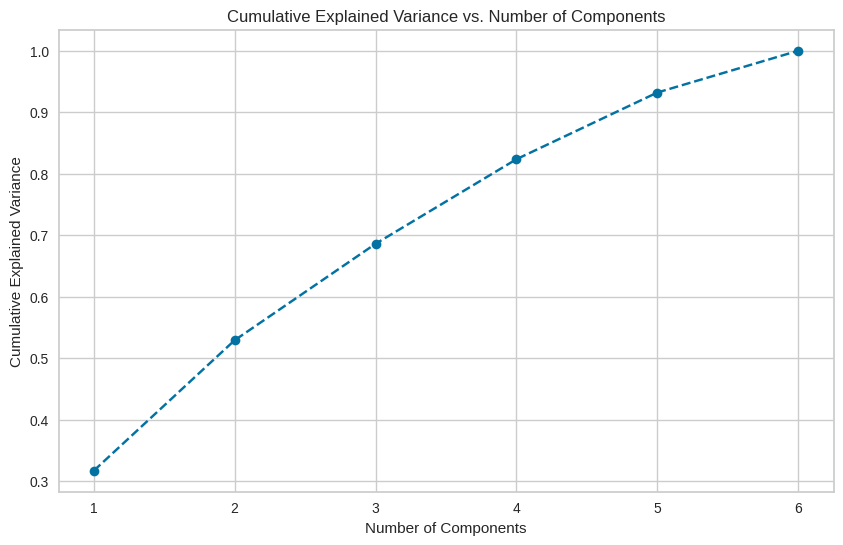

In [ ]:
columns_to_keep = ['Patient_ID', 'Diabetes_Type','Patient_Segment', 'NBRx_Product', 'HCP_Specialty_Group', 'HDI', 'Payer_Group', '1M_OOP_Bucket' ]
data = segment_attributes[columns_to_keep]
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Encode Categorical Attributes:

s = (data.dtypes == 'object')
object_cols = list(s[s].index) # Identify categorical columns
LE = LabelEncoder() # Initialize LabelEncoder
for i in object_cols:
    data[i] = LE.fit_transform(data[i]) # Apply LabelEncoder to each categorical column


# Drop constant and quasi-constant columns from the dataset to implement assumption of equal varaiance amongst clusters
var_thr = VarianceThreshold(threshold=0.25)  # # Create a VarianceThreshold instance with a threshold of 0.25. This can be adjusted as needed.
var_thr.fit(data) # Fit the VarianceThreshold to the data
var_thr.get_support() # Get the support (boolean mask) for the selected features
con_cols = [col for col in data.columns if col not in data.columns[var_thr.get_support()]] # Identify the constant and quasi-constant columns
data = data.drop(con_cols, axis=1) # Dropped

#Implement normalization assumption by scaling the features using Standard Scaler
scaler = StandardScaler() # Initialize the StandardScaler

scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data), columns=data.columns)  # Fit the scaler to the data and transform the data

#Dimensionality reduction using PCA to select optimial features
pca = PCA(n_components=scaled_data.shape[1]) # Initialize PCA with the number of components equal to the number of scaled features
pca.fit(scaled_data) # Fit PCA to the scaled data


# Calculate the explained variance and cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Visualize the explained variance to select the number of components
def pca_plot(cumulative_explained_variance, scaled_data):
  # Plot the explained variance
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
  plt.title('Cumulative Explained Variance vs. Number of Components')
  plt.xlabel('Number of Components')
  plt.ylabel('Cumulative Explained Variance')
  plt.grid(True)
  plt.show()

pca_plot(cumulative_explained_variance, scaled_data)




In [ ]:
# Select the number of components based on the desired explained variance threshold
desired_explained_variance = 0.90
num_components = np.argmax(cumulative_explained_variance >= desired_explained_variance) + 1

# Output the selected number of components
print(f"Number of components to explain {desired_explained_variance:.2f} variance: {num_components}")

# Fit PCA with the selected number of components
pca = PCA(n_components=num_components)
PCA_ds = pd.DataFrame(pca.fit_transform(scaled_data), columns=[f"PC{i+1}" for i in range(num_components)])

Number of components to explain 0.90 variance: 5


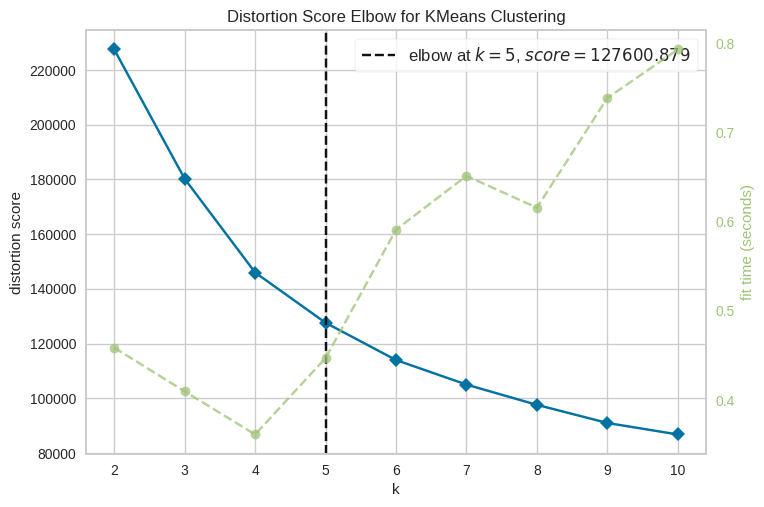

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#Choosing the best number of clusters
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Initialize the KElbowVisualizer with the KMeans estimator and a range of K values. Lets start with 10
Elbow_M = KElbowVisualizer(KMeans(), k=10)

# Fit the visualizer to the PCA-transformed data
Elbow_M.fit(PCA_ds)

# Display the Elbow Method plot
Elbow_M.show()

In [ ]:
# Specify the number of clusters and other parameters
n_clusters = 5
random_state = 42
max_iter = 1000
algorithm = 'elkan'

# Create a KMeans instance
kmeans_5 = KMeans(n_clusters=n_clusters,
                max_iter=max_iter,
                random_state=random_state,
                algorithm=algorithm)

# Fit the KMeans model to your data
yhat_KM_k5 = kmeans_5.fit_predict(PCA_ds)

# Assign cluster labels to your DataFrame
PCA_ds_k5 = PCA_ds.copy()
data_k5 = data.copy()
PCA_ds_k5["Cluster"] = yhat_KM_k5
data_k5["Cluster"] = yhat_KM_k5

In [ ]:
#Lets further investigate this with silhouette score. Lower score indicates a better fit.
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Check silhouette score for a range of K values between 2 and 10:
k_values = range(2, 10)
silhouette_scores = []

best_k = None
best_silhouette_score = -1

# Iterate through different K values
for k in k_values:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    km.fit(PCA_ds)

    # Calculate the average silhouette score
    silhouette_avg = silhouette_score(PCA_ds, km.labels_)
    silhouette_scores.append(silhouette_avg)

    # Update the best K value if a higher silhouette score is found
    if silhouette_avg > best_silhouette_score:
        best_k = k
        best_silhouette_score = silhouette_avg

# Output the best K value and corresponding Silhouette Score
print("Best K value:", best_k)
print("Best Silhouette Score:", best_silhouette_score)

Best K value: 7
Best Silhouette Score: 0.32953152916892925


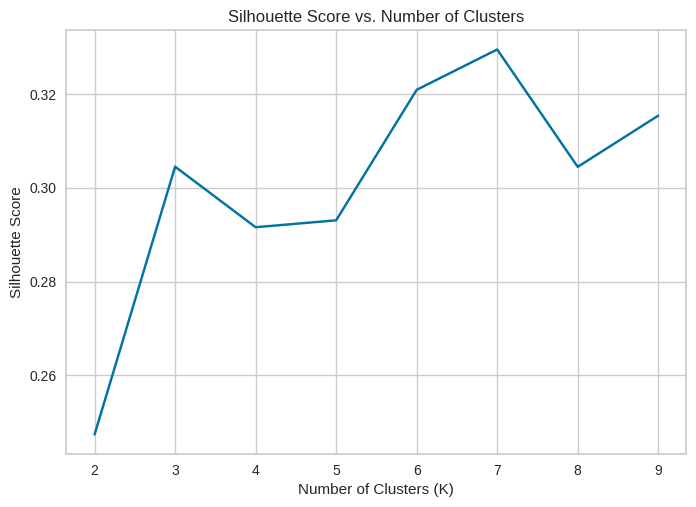

In [ ]:
import matplotlib.pyplot as plt
# Create a plot to visualize Silhouette Scores
plt.plot(k_values, silhouette_scores)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.show()

In [ ]:
#Looks like we can use any of 6, 7, or 8 number of clusters as their scores are very close. We'll further investigate the Sum of Square errors to pick the best.

#Lets compare the result for others:

# Specify the number of clusters and other parameters increased on 6
n_clusters = 6
random_state = 42
max_iter = 1000
algorithm = 'elkan'

# Create a KMeans instance
kmeans_6 = KMeans(n_clusters=n_clusters,
                max_iter=max_iter,
                random_state=random_state,
                algorithm=algorithm)

# Fit the KMeans model to your data
yhat_KM_k6 = kmeans_6.fit_predict(PCA_ds)

# Assign cluster labels to your DataFrame
PCA_ds_k6 = PCA_ds.copy()
data_k6 = data.copy()
PCA_ds_k6["Cluster"] = yhat_KM_k6
data_k6["Cluster"] = yhat_KM_k6

In [ ]:
# Specify the number of clusters and other parameters increased on 7
n_clusters = 7
random_state = 42
max_iter = 1000
algorithm = 'elkan'

# Create a KMeans instance
kmeans_7 = KMeans(n_clusters=n_clusters,
                max_iter=max_iter,
                random_state=random_state,
                algorithm=algorithm)

# Fit the KMeans model to your data
yhat_KM_k7 = kmeans_7.fit_predict(PCA_ds)

# Assign cluster labels to your DataFrame
PCA_ds_k7 = PCA_ds.copy()
data_k7 = data.copy()
PCA_ds_k7["Cluster"] = yhat_KM_k7
data_k7["Cluster"] = yhat_KM_k7

In [ ]:
# Specify the number of clusters and other parameters increased on 7
n_clusters = 8
random_state = 42
max_iter = 1000
algorithm = 'elkan'

# Create a KMeans instance
kmeans_8 = KMeans(n_clusters=n_clusters,
                max_iter=max_iter,
                random_state=random_state,
                algorithm=algorithm)

# Fit the KMeans model to your data
yhat_KM_k8 = kmeans_8.fit_predict(PCA_ds)

# Assign cluster labels to your DataFrame
PCA_ds_k8 = PCA_ds.copy()
data_k8 = data.copy()
PCA_ds_k8["Cluster"] = yhat_KM_k8
data_k8["Cluster"] = yhat_KM_k8

In [ ]:
 #Sum of Squared Errors (SSE):
sse_k5 = kmeans_5.inertia_
sse_k6 = kmeans_6.inertia_
sse_k7 = kmeans_7.inertia_
sse_k8 = kmeans_8.inertia_
print(f"When K=5 SSE = {sse_k5}\nWhen K=6 SSE = {sse_k6} \nWhen K=7 SSE = {sse_k7} \nWhen K=8 SSE = {sse_k8}")

When K=5 SSE = 127600.89594176823
When K=6 SSE = 113676.74206200667 
When K=7 SSE = 104159.65937882783 
When K=8 SSE = 97531.8159942639


In [ ]:
from sklearn.metrics import silhouette_score
silhouette_k5 = silhouette_score(PCA_ds, yhat_KM_k5)
silhouette_k6 = silhouette_score(PCA_ds, yhat_KM_k6)
silhouette_k7 = silhouette_score(PCA_ds, yhat_KM_k7)
silhouette_k8 = silhouette_score(PCA_ds, yhat_KM_k8)
print(f"When K=5 silhouette_score = {silhouette_k5}\nWhen K=6 silhouette_score = {silhouette_k6}\nWhen K=7 silhouette_score = {silhouette_k7} \nWhen K=8 silhouette_score = {silhouette_k8}")

When K=5 silhouette_score = 0.2930713310213909
When K=6 silhouette_score = 0.32092005869846135
When K=7 silhouette_score = 0.32953152916892925 
When K=8 silhouette_score = 0.3044827504721439


In [ ]:
#K= 8 clusters seem our best value based on the SSE=97531.815 abd Silhouette_Score = 0.304

#Put cluster back to data table
data['Cluster'] = PCA_ds_k8['Cluster']

In [ ]:
# Merge 'Segment' from segment_attributes to data based on 'Patient_ID'
data = data.merge(segment_attributes[['Patient_ID', 'Segment']], on='Patient_ID', how='left')


In [ ]:
#data proactive managed as the sample is too small and will skew the clusters
#data = data[data['Segment'] != 'Champions']


In [ ]:
#count occurrence of the cluster category by segment in data

# Group by 'Segment' and 'Cluster' and count occurrences
cluster_counts_by_segment = data.groupby(['Segment', 'Cluster'])['Patient_ID'].count().unstack(fill_value=0)

# Display the resulting table
print(cluster_counts_by_segment)


Cluster                  0     1     2     3     4     5     6     7
Segment                                                             
At_Risk                 60  5050  3537  1717   734   691  4950   215
Champions              123   146     0     7   985   134     1     0
Hibernating              0   653   287   781   396    67   359   168
Loyal_users           7227  3675  4237   572   125  1290  2130   344
Needing_attention        1    61   306    29    14     8    15    45
Potential_loyalist       9   371   315     3  2139   568    10  2409
Promising             1168   260   302    20   226   374    74  1516
Users_We_Cannot_Lose   299     0    73     0     9   138     4  1391


In [ ]:
#  in cluster_count_by_segments identify the max figures for each segment and replace the max figure as x and others  as -

# Create a new DataFrame to store the modified counts
cluster_counts_modified = cluster_counts_by_segment.copy()

# Iterate through each segment
for segment in cluster_counts_by_segment.index:
  # Find the maximum value for the current segment
  max_value = cluster_counts_by_segment.loc[segment].max()

  # Replace all values in the row with '-' except for the maximum value
  cluster_counts_modified.loc[segment] = ['-' if val != max_value else 'x' for val in cluster_counts_by_segment.loc[segment]]

# Display the modified DataFrame
print(cluster_counts_modified)


Cluster               0  1  2  3  4  5  6  7
Segment                                     
At_Risk               -  x  -  -  -  -  -  -
Champions             -  -  -  -  x  -  -  -
Hibernating           -  -  -  x  -  -  -  -
Loyal_users           x  -  -  -  -  -  -  -
Needing_attention     -  -  x  -  -  -  -  -
Potential_loyalist    -  -  -  -  -  -  -  x
Promising             -  -  -  -  -  -  -  x
Users_We_Cannot_Lose  -  -  -  -  -  -  -  x


K-means clustering does a good job of validating our segmentation analysis as the maximum value counts from each segment can be found in corresponding K-Means clusters.

From the matrix above plots the intercection of our segments with corresponding clusters in K-means:

We can see that:

Potential_Loyalists, Promising and We-cannot_Lose are in the same cluster as their common theme is good utlization despite severiy of their disease.


Also:

The maximum value for "At_Risk" segment is in cluster 1
The maximum value for "Champions" segment is in cluster 4
The maximum value for "Needing_Attention" segment is in cluster 2,
and so on.